## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-20 12:44:47.625343: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 12:44:47.943901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 12:44:48.857097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib as npm

  au

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn
absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 1.7%
RAM Usage: 13.4%
Available RAM: 871.7G
Total RAM: 1007.0G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [8]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset


In [9]:
parcellation = 'S400'
omit_subcortical = False

# Load data
print("Loading data...")
X = load_transcriptome(
    parcellation=parcellation, 
    omit_subcortical=omit_subcortical,
    hemisphere='both', 
    impute_strategy='mirror_interpolate'
)

Y_fc = load_connectome(
    parcellation=parcellation,
    omit_subcortical=omit_subcortical,
    measure='FC',
    hemisphere='both'
)

coords = load_coords(
    parcellation=parcellation,
    omit_subcortical=omit_subcortical,
    hemisphere='both'
)

# Filter out regions with missing gene expression data
valid_mask = ~np.isnan(X).any(axis=1)
print(f"Subsetting based on gene expression (X)")

valid_indices = np.where(valid_mask)[0]
print(f"Found {len(valid_indices)} valid regions out of {X.shape[0]}")

if len(valid_indices) == 0:
    raise ValueError("No valid regions found after filtering. Check your data.")

# Create mapping from valid indices to original indices
valid2true_mapping = {i: valid_indices[i] for i in range(len(valid_indices))}

# Subset data to only include valid regions
X_valid = X[valid_indices]
Y_fc_valid = Y_fc[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]

# Create training/validation/test splits
n_regions = len(valid_indices)
n_pairs = (n_regions * (n_regions - 1)) // 2

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_fc_valid, 
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping
)

batch_size = 512
# Create dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

Loading data...
Subsetting based on gene expression (X)
Found 455 valid regions out of 456
Creating RegionPairDataset...


In [12]:
from models.transformer_models import SharedSelfAttentionCLSModel

# Set up model with the same hyperparameters used for training
model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_full_model.pt"))
model.eval()
model.to("cuda")

  warnings.warn(



SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

In [13]:
from torch.utils.data import Subset

# Use the first 256 samples, or fewer if you like
subset_indices = list(range(256))
subset_dataset = Subset(dataset, subset_indices)

subset_loader = DataLoader(
    subset_dataset,
    batch_size=256,            # Smaller batch to avoid GPU memory overflow
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

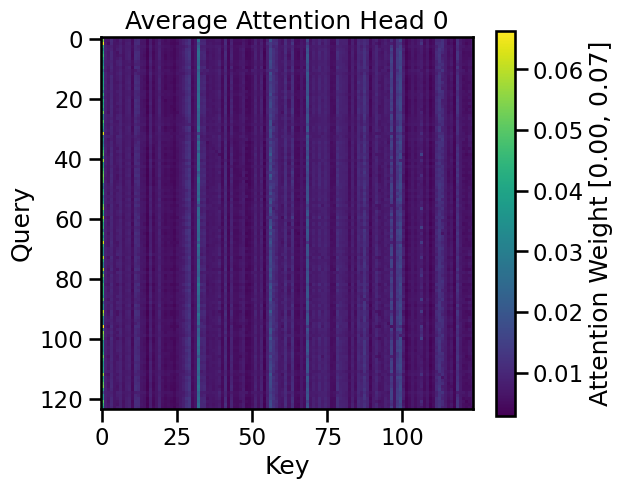

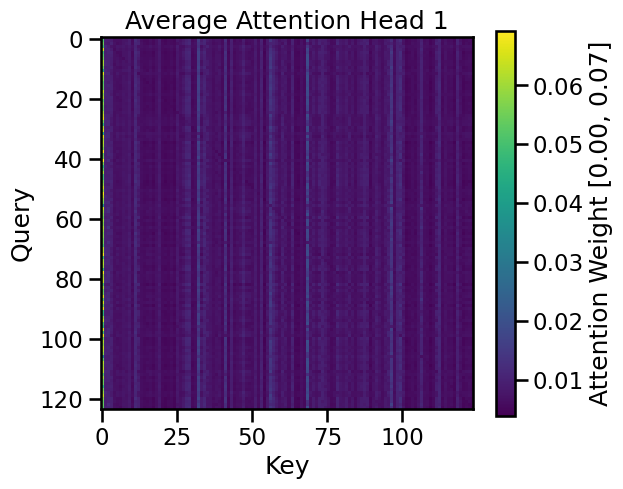

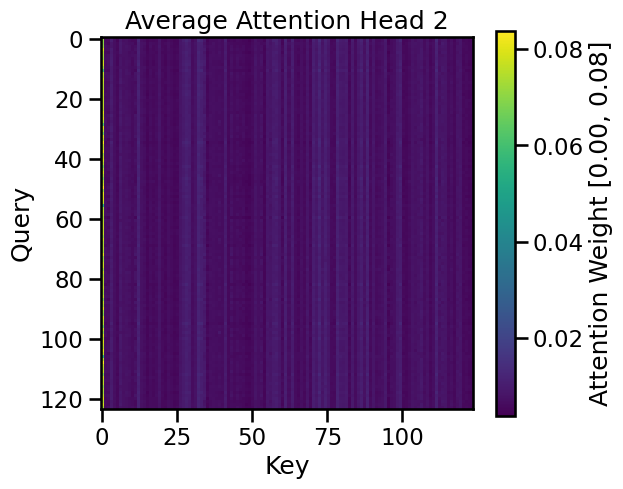

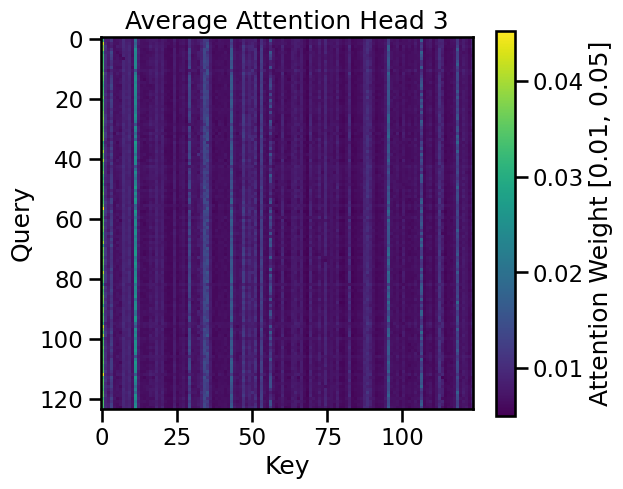

In [14]:
predictions, targets = model.predict(subset_loader, collect_attn=True)

In [15]:

embeddings = []
seen_coords = set()

model.eval()
with torch.no_grad():
    for batch_X, batch_y, batch_coords, _ in subset_loader:
        batch_X = batch_X.to(model.device)
        batch_coords = batch_coords.to(model.device)

        x_i, x_j = torch.chunk(batch_X, chunks=2, dim=1)
        coords_i, coords_j = torch.chunk(batch_coords, chunks=2, dim=1)

        # Process each unique coordinate in the batch
        for x, coords in [(x_i, coords_i), (x_j, coords_j)]:
            for i in range(len(coords)):
                coord_tuple = tuple(coords[i].cpu().numpy())
                if coord_tuple not in seen_coords:
                    # Get encoded region embedding for new coordinate
                    emb = model.encoder(x[i:i+1], coords[i:i+1])  # (1, dim)
                    embeddings.append(emb.cpu())
                    seen_coords.add(coord_tuple)

# Stack all embeddings
embeddings = torch.cat(embeddings, dim=0).numpy()

In [18]:
len(seen_coords)

129

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



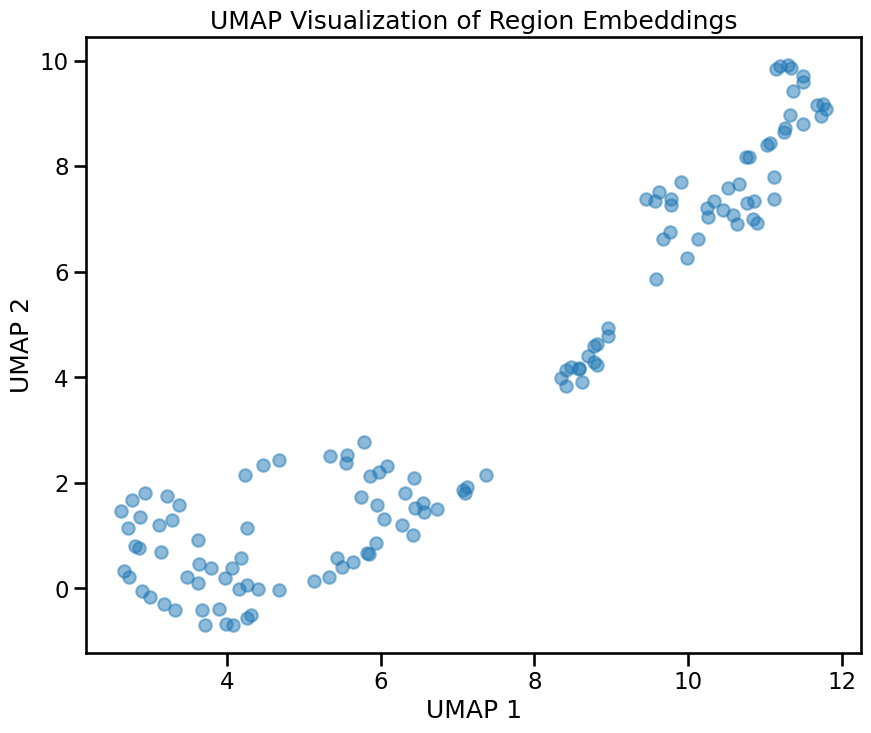

In [23]:
import umap
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)

# Create scatter plot
plt.figure(figsize=(10,8))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.5)
plt.title('UMAP Visualization of Region Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'